# Auto Loan Default Prediction

In this project, we aim to predict whether a loan will default based on a variety of features such as the loan amount, asset cost, employment type, credit history, and more. By analyzing the dataset provided, we will use machine learning techniques to build a predictive model that can help lenders minimize risk and improve decision-making.

## Data Processing and EDA

### Import Libs

In [2]:
# Import libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import machine learning tools
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve ,classification_report, confusion_matrix
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


### Load dataset

In [4]:
# Load the train and test datasets
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Display the first few rows of the training dataset
train_data.head()

# Check for missing values and data types
print(train_data.isnull().sum())
print(train_data.dtypes)


UNIQUEID                                  0
DISBURSED_AMOUNT                          0
ASSET_COST                                0
LTV                                       0
BRANCH_ID                                 0
SUPPLIER_ID                               0
MANUFACTURER_ID                           0
CURRENT_PINCODE_ID                        0
DATE_OF_BIRTH                             0
EMPLOYMENT_TYPE                        7661
DISBURSAL_DATE                            0
STATE_ID                                  0
EMPLOYEE_CODE_ID                          0
MOBILENO_AVL_FLAG                         0
AADHAR_FLAG                               0
PAN_FLAG                                  0
VOTERID_FLAG                              0
DRIVING_FLAG                              0
PASSPORT_FLAG                             0
PERFORM_CNS_SCORE                         0
PERFORM_CNS_SCORE_DESCRIPTION             0
PRI_NO_OF_ACCTS                           0
PRI_ACTIVE_ACCTS                

### Handle missing value and encode categorical var

In [25]:
# Define categorical and numeric columns
categorical_cols = ['EMPLOYMENT_TYPE']  # Add more categorical columns if needed
numeric_cols = ['DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'PRIMARY_INSTAL_AMT', 'NO_OF_INQUIRIES']

# Handle missing values using SimpleImputer and scale the numeric columns using StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# One-hot encode categorical variables and fill missing values with 'Unknown'
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Use ColumnTransformer to apply transformations to numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Separate the target variable from features
X = train_data.drop(['UNIQUEID', 'LOAN_DEFAULT'], axis=1)
y = train_data['LOAN_DEFAULT']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applying transformations
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


#### Feature Engineering --- derive Age

In [26]:
# Convert DATE_OF_BIRTH into Age
current_year = pd.Timestamp.now().year
train_data['DATE_OF_BIRTH'] = pd.to_datetime(train_data['DATE_OF_BIRTH'], format='%d-%m-%Y', errors='coerce')
train_data['AGE'] = current_year - train_data['DATE_OF_BIRTH'].dt.year

# Drop the DATE_OF_BIRTH column now that we have AGE
X['AGE'] = train_data['AGE']
X = X.drop(['DATE_OF_BIRTH'], axis=1)


## EDA

#### Distribution of target variables

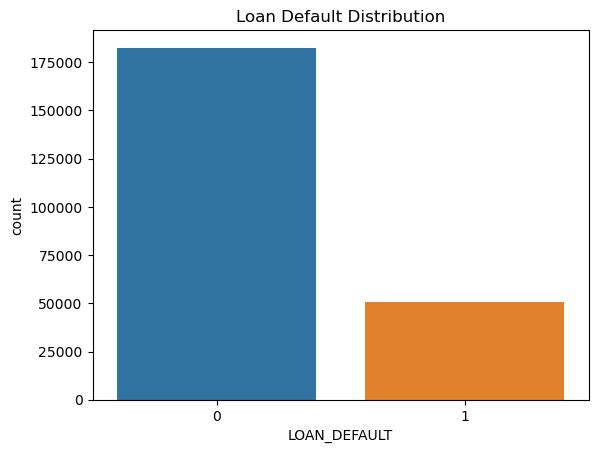

In [9]:
# Plot the distribution of the target variable (LOAN_DEFAULT)
sns.countplot(x='LOAN_DEFAULT', data=train_data)
plt.title('Loan Default Distribution')
plt.show()


### Correlation Heatmap

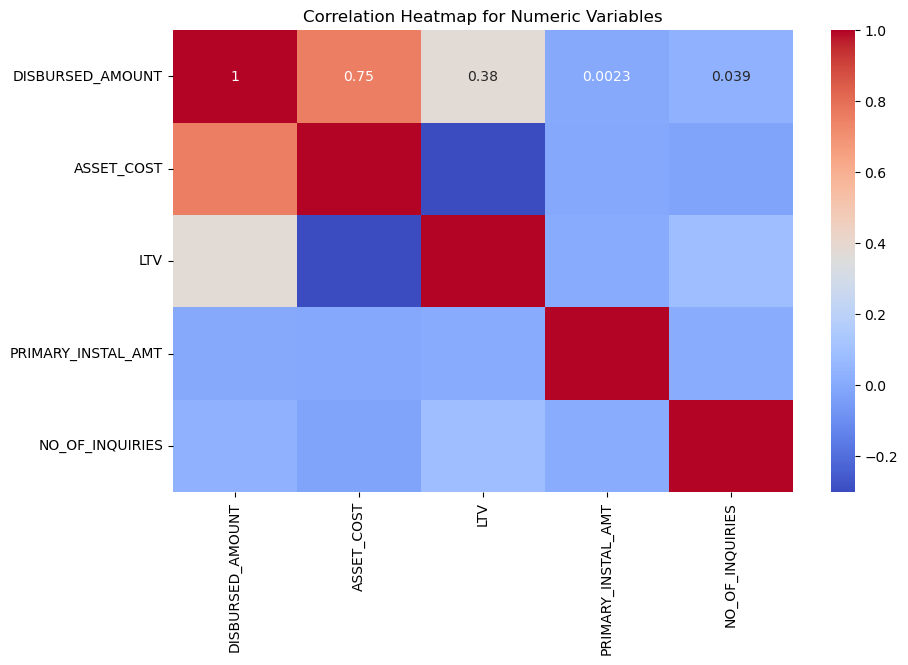

In [10]:
# Plot correlation heatmap for numerical variables
plt.figure(figsize=(10, 6))
sns.heatmap(train_data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Variables')
plt.show()



#### Distribution of Loan amount by default status

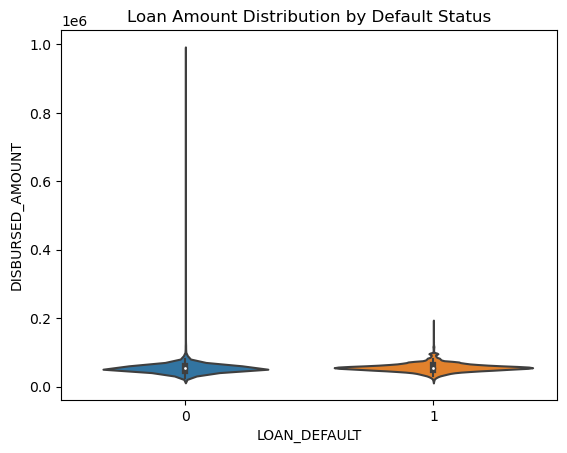

In [11]:
# Plot loan amount distribution by default status
sns.violinplot(x='LOAN_DEFAULT', y='DISBURSED_AMOUNT', data=train_data)
plt.title('Loan Amount Distribution by Default Status')
plt.show()


### Modeling

#### Define multiple models 

We are going to try Logistic Regression, Random Forest, and Gradient Boosting as our classification models.

### Model Training 
#### Logistic Regression


In [28]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36477
           1       0.47      0.00      0.00     10154

    accuracy                           0.78     46631
   macro avg       0.62      0.50      0.44     46631
weighted avg       0.71      0.78      0.69     46631



#### Random Forest Classifier

In [29]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86     36477
           1       0.28      0.08      0.12     10154

    accuracy                           0.75     46631
   macro avg       0.53      0.51      0.49     46631
weighted avg       0.68      0.75      0.70     46631



#### Gradient Boosting Classifier

In [31]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)

print("Gradient Boosting Classifier Results:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classifier Results:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36477
           1       0.12      0.00      0.00     10154

    accuracy                           0.78     46631
   macro avg       0.45      0.50      0.44     46631
weighted avg       0.64      0.78      0.69     46631



#### Model Evaluation - ROC Curve for the Best Model

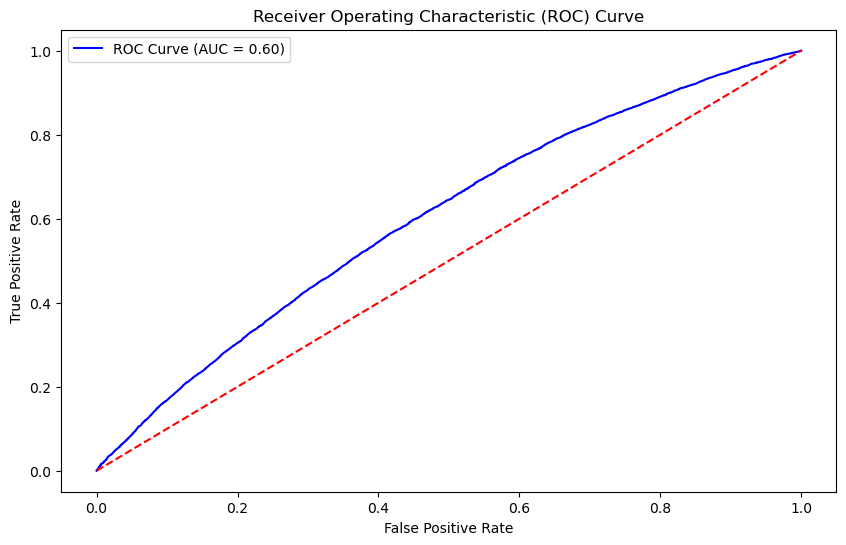

In [33]:
best_model = gb_model
y_probs = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


#### Feature Importance

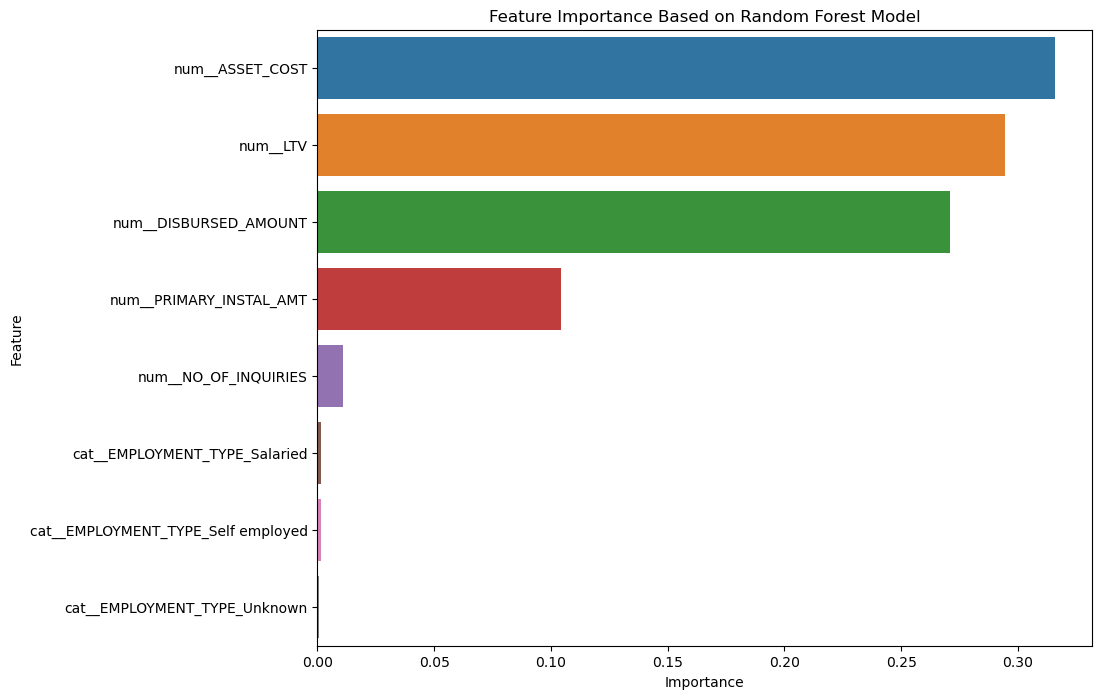

In [34]:
importance = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance Based on Random Forest Model')
plt.show()

### Model Training with Hyperparameter Tuning
##### Logistic Regression with Grid Search

In [37]:
log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])
log_param_grid = {'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__penalty': ['l1', 'l2']}
log_grid_search = GridSearchCV(log_pipeline, log_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
log_grid_search.fit(X_train, y_train)
y_pred_log = log_grid_search.best_estimator_.predict(X_test)

print("Logistic Regression Results:")
print(f"Best Parameters: {log_grid_search.best_params_}")
print(classification_report(y_test, y_pred_log))

Logistic Regression Results:
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36477
           1       0.47      0.00      0.00     10154

    accuracy                           0.78     46631
   macro avg       0.62      0.50      0.44     46631
weighted avg       0.71      0.78      0.69     46631



#### Random Forest Classifier with Grid Search

In [38]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test)

print("Random Forest Classifier Results:")
print(f"Best Parameters: {rf_grid_search.best_params_}")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36477
           1       0.50      0.00      0.00     10154

    accuracy                           0.78     46631
   macro avg       0.64      0.50      0.44     46631
weighted avg       0.72      0.78      0.69     46631



#### Gradient Boosting Classifier with Grid Search

In [39]:
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
gb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5]
}
gb_grid_search = GridSearchCV(gb_pipeline, gb_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gb_grid_search.fit(X_train, y_train)
y_pred_gb = gb_grid_search.best_estimator_.predict(X_test)

print("Gradient Boosting Classifier Results:")
print(f"Best Parameters: {gb_grid_search.best_params_}")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Classifier Results:
Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     36477
           1       0.00      0.00      0.00     10154

    accuracy                           0.78     46631
   macro avg       0.39      0.50      0.44     46631
weighted avg       0.61      0.78      0.69     46631



### Model Evaluation - ROC Curve for the Best Model

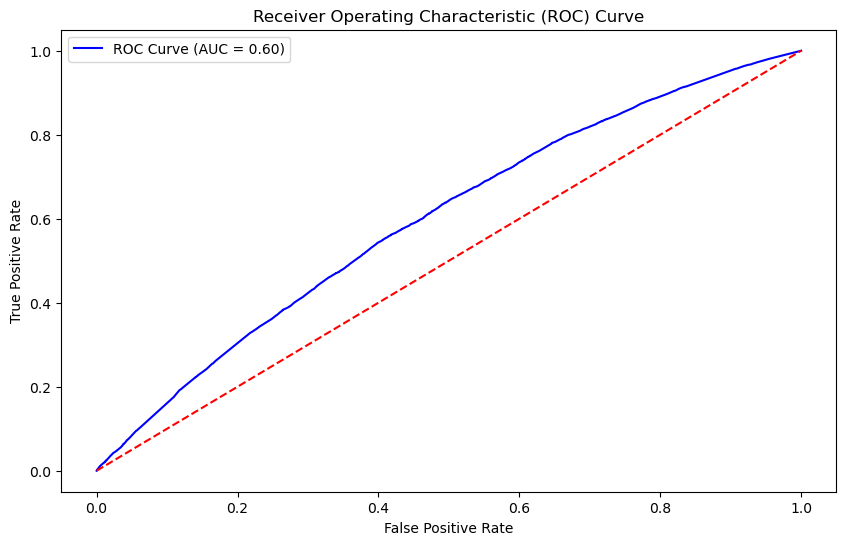

In [41]:
best_model = gb_grid_search.best_estimator_
y_probs = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Feature Importance

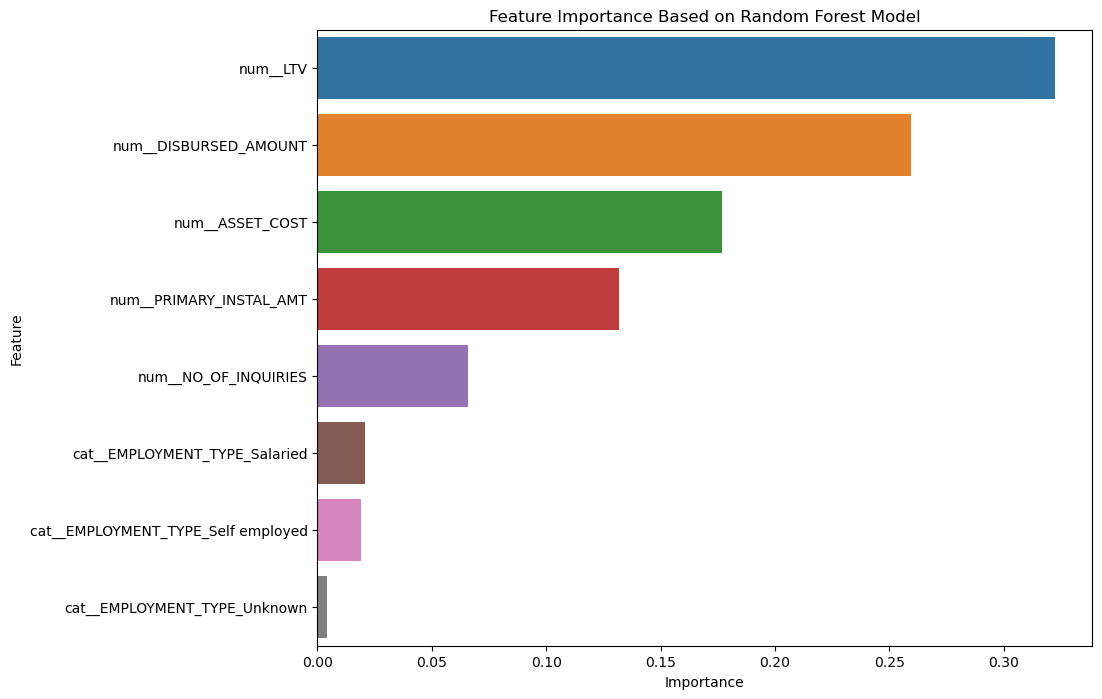

In [42]:
importance = rf_grid_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance Based on Random Forest Model')
plt.show()

#### save the best model

In [ ]:
# Save the best model
joblib.dump(gb_grid_search.best_estimator_, 'best_gradient_boosting_model.pkl')